In [28]:
# Cleaning
import pandas as pd
import os

# import all csv's from a folder and combine them into one dataframe
def combine_data_files(folder_path):
    df_list = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            df_list.append(df)

    return pd.concat(df_list, axis=0, ignore_index=True)

# Once data is imported from csv to a dataframe, clean up the datatypes
def clean_df_new(df):
    
    resMap = lambda res : 'White' if res == '1-0' else 'Black' if res == '0-1' else 'Draw' if res == "1/2-1/2" else res
    cleanDateTime = lambda d: pd.to_datetime(d)
    cleanComment = lambda x: x if x.find(']') == -1 else x.split("] ")[1]

    datetime_columns = ['Date', 'Time', 'WhiteClock', 'BlackClock']
    float_columns = ['WhiteRD', 'BlackRD', 'AvgEvalOpening', 'AvgEvalMiddle', 'AvgEvalEnd', 'AvgEmtOpening', 'AvgEmtMiddle', 'AvgEmtEnd']
    int_columns = ['FICSGamesDBGameNo', 'WhiteElo', 'BlackElo', 'PlyCount']

    df = df.drop(['Event', 'Site', 'Round', 'WhiteClock', 'BlackClock'], axis=1)

    for column in df.columns:

        if column in float_columns:
            df[column] = df[column].astype(float)
        elif column in int_columns:
            df[column] = df[column].astype(int)
        elif column in datetime_columns:
            df[column] = df[column].apply(cleanDateTime)
        else:
            if column == 'Result':
                df[column] = df[column].apply(resMap)
            if column == 'ResultComment':
                df[column] = df[column].apply(cleanComment)
            df[column] = df[column].astype('category')

    df['WhiteIsComp'] = df['WhiteIsComp'] == 'Yes'
    df['BlackIsComp'] = df['BlackIsComp'] == 'Yes'

    return df

In [83]:
combined_df = combine_data_files('data-by-month')
cleaned = clean_df_new(combined_df).dropna()
print (cleaned.dtypes)
print(cleaned.shape)
cleaned.head()

Date                 datetime64[ns]
White                      category
Black                      category
Result                     category
BlackElo                      int64
BlackIsComp                    bool
BlackRD                     float64
ECO                        category
FICSGamesDBGameNo             int64
PlyCount                      int64
Time                 datetime64[ns]
TimeControl                category
WhiteElo                      int64
WhiteIsComp                    bool
WhiteRD                     float64
AvgEvalOpening              float64
AvgEvalMiddle               float64
AvgEvalEnd                  float64
AvgEmtOpening               float64
AvgEmtMiddle                float64
AvgEmtEnd                   float64
ResultComment              category
dtype: object
(25884, 22)


,Date,White,Black,Result,BlackElo,BlackIsComp,BlackRD,ECO,FICSGamesDBGameNo,PlyCount,...,WhiteElo,WhiteIsComp,WhiteRD,AvgEvalOpening,AvgEvalMiddle,AvgEvalEnd,AvgEmtOpening,AvgEmtMiddle,AvgEmtEnd,ResultComment
0,2023-02-28,ArasanX,Notarious,Draw,2874,True,37.2,B10,530376668,39,...,2780,True,34.7,15.571429,-7.461538,5.416667,0.126308,3.120000,3.252667,Game drawn by mutual agreement
1,2023-02-28,Notarious,ArasanX,White,2786,True,34.8,D79,530376382,139,...,2868,True,37.4,30.340426,46.913043,104.086957,2.313957,3.352826,0.753348,Black resigns
2,2023-02-28,exeComp,ArasanX,Black,2780,True,34.9,A17,530375680,274,...,2711,True,37.9,59.739130,58.186813,-216.551724,3.552725,0.891088,0.430033,White resigns
3,2023-02-28,nthmaster,Speyside,White,2202,True,45.1,D27,530375325,169,...,2135,False,40.3,201.561404,500.696429,991.975610,2.761375,1.995554,0.277589,Black checkmated
4,2023-02-28,GriffyJr,family,Black,2019,False,48.5,C01,530374794,162,...,2028,True,37.3,7.000000,-108.166667,-410.115385,0.609074,0.589000,0.436094,White resigns


In [56]:
def construct_df_train(df):
    # Define columns to take the average of and to one-hot encode
    cols_to_avg = ['WhiteRD', 'BlackRD', 'AvgEvalOpening', 'AvgEvalMiddle', 'AvgEvalEnd', 'AvgEmtOpening', 'AvgEmtMiddle', 'AvgEmtEnd', 'PlyCount']
    cols_to_onehot = ['ECO'] # 'White', 'Black',  <--- For if we decide to train using player UN for black and white as a features
    ground_truth_labels = ['Result', 'ResultComment']

    # Define dictionary to map column names to letters for one-hot encoding
    col_name_to_letter = {col_name: chr(65+i) for i, col_name in enumerate(ground_truth_labels+cols_to_onehot)}

    # Define column names for player-wise averages
    new_cols_white = ['WhiteAvgRD', 'WhiteAvgEvalForOpenings', 'WhiteAvgEvalForMiddlegames', 'WhiteAvgEvalForEndgames', 'WhiteAvgEmtForOpenings', 'WhiteAvgEmtForMiddlegames', 'WhiteAvgEmtForEndgames', 'WhiteAvgPlyCount']
    new_cols_black = ['BlackAvgRD', 'BlackAvgEvalForOpenings', 'BlackAvgEvalForMiddlegames', 'BlackAvgEvalForEndgames', 'BlackAvgEmtForOpenings', 'BlackAvgEmtForMiddlegames', 'BlackAvgEmtForEndgames', 'BlackAvgPlyCount']

    # Compute player-wise averages
    dataAvgsByUserWhite = {p: df[df['White'] == p][cols_to_avg+cols_to_onehot].mean(numeric_only=True) for p in df['White'].unique()}
    dataAvgsByUserBlack = {p: df[df['Black'] == p][cols_to_avg+cols_to_onehot].mean(numeric_only=True) for p in df['Black'].unique()}

    # Define empty dataframe to hold the new data
    df_new = pd.DataFrame(columns = ground_truth_labels+cols_to_onehot+new_cols_white+new_cols_black)

    # Iterate over each row in the original dataframe and create a new row in the output dataframe with the necessary data
    for row in df.itertuples():
        white_avg_values = dataAvgsByUserWhite.get(row.White, pd.Series([0]*len(cols_to_avg+cols_to_onehot)))
        black_avg_values = dataAvgsByUserBlack.get(row.Black, pd.Series([0]*len(cols_to_avg+cols_to_onehot)))

        white_new_cols = [white_avg_values[0], white_avg_values[2], white_avg_values[3], white_avg_values[4], white_avg_values[5], white_avg_values[6], white_avg_values[7], white_avg_values[8]]
        black_new_cols = [black_avg_values[1], black_avg_values[2], black_avg_values[3], black_avg_values[4], black_avg_values[5], black_avg_values[6], black_avg_values[7], black_avg_values[8]]

        new_row = tuple(getattr(row, label) for label in ground_truth_labels+cols_to_onehot) + tuple(white_new_cols) + tuple(black_new_cols)

        df_new.loc[len(df_new)] = new_row

    # One-hot encode the ground truth labels and cols_to_onehot
    df_new = pd.get_dummies(df_new, columns = ground_truth_labels+cols_to_onehot, prefix = list(col_name_to_letter.values()))

    # Map the column labels to their corresponding uppercase letters
    df_new.columns = df_new.columns.map(lambda x: col_name_to_letter.get(x, x))

    return df_new

df_train = construct_df_train(cleaned).dropna()

In [58]:
for x in df_train.columns:
    print(x)

df_train.shape

WhiteAvgRD
WhiteAvgEvalForOpenings
WhiteAvgEvalForMiddlegames
WhiteAvgEvalForEndgames
WhiteAvgEmtForOpenings
WhiteAvgEmtForMiddlegames
WhiteAvgEmtForEndgames
WhiteAvgPlyCount
BlackAvgRD
BlackAvgEvalForOpenings
BlackAvgEvalForMiddlegames
BlackAvgEvalForEndgames
BlackAvgEmtForOpenings
BlackAvgEmtForMiddlegames
BlackAvgEmtForEndgames
BlackAvgPlyCount
A_Black
A_Draw
A_White
B_Black checkmated
B_Black forfeits by disconnection
B_Black forfeits on time
B_Black ran out of time and White has no material to mate
B_Black resigns
B_Black wins by adjudication
B_Game drawn by mutual agreement
B_Game drawn by repetition
B_Game drawn by stalemate
B_Game drawn by the 50 move rule
B_Game drawn due to length
B_Neither player has mating material
B_White checkmated
B_White forfeits by disconnection
B_White forfeits on time
B_White ran out of time and Black has no material to mate
B_White resigns
B_White wins by adjudication
C_A00
C_A01
C_A02
C_A03
C_A04
C_A05
C_A06
C_A07
C_A08
C_A09
C_A10
C_A11
C_A12
C_A1

(25884, 517)

In [33]:
before = cleaned.shape[0]

dropped = cleaned.dropna()

after = dropped.shape[0]

print ('{} / {}'.format(after,before))
print ('Data Loss : {:.2f} %  \n(Mostly due to NaN eval scores. Try increasing engine computation time if this is too high.)'.format(((before - after)*100)/before))

25884 / 26032
Data Loss : 0.57 %  
(Mostly due to NaN eval scores. Try increasing engine computation time if this is too high.)


### Random Forest

We have two types of ground truths in this dataset: a rudimentary outcome such as "black won" or "game ended in a draw", and a more specific description of the outcome such as "black ran out of time" or "white checkmated". The latter type of ground truth is very ambitious to predict as it is systemically very different; it requires great modeling of the problem to determine the precise result as opposed to a predictor that (more simply) needs to accurately guess the outcome. The random forest model formulates predictions based on the combination of many decision boundaries across different variables. It's unlikely that the inherent structure of the random forest is able to pick up on the nuances required to categorize among the more descriptive outcomes, so we will first focus on predicting the rudimentary outcomes.

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

The first step, as with any machine learning process, is the split the data into useful training and test sets. We will do this using our `df_train` dataset, which is preprocessed with float64 and one-hot encoded features. This dataset still contains the ground truth labels as well, so we will drop them before splitting up our data.

In [114]:
# drop all ground truth labels from the processed training data
X = df_train.drop(columns=df_train.columns[df_train.columns.str.contains('A_') + df_train.columns.str.contains('B_') + df_train.columns.str.contains('C_')])
# get the desired ground truth labels
y = cleaned['Result']
# split data for training and accuracy testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

To start off, we trained a very lax random forest model to guage our starting point. The only hyperparameter we changed is the number of estimators in the forest because we believed it would heavily influence the initial result. We did this using the grid search method, and the values were be selected with the intention of determining whether the optimal one is small or very large.

Our initial fit of the random forest suggested that the optimal number of estimators is very large. Out of the list of hyperparameter values, the largest value `n_estimators=1000` produced the best predictive model with a test accuracy of about 70.9%. We later tried grid search with higher values of `n_estimators`, and the accuracy results were virtually the same. Consequently, we stuck with the value of `n_estimators=1000`.

It's very common that random forests overfit the training data, so we checked whether we needed to prune our random forest by comparing the model performance on training data with the performance on test data. The model had a training accuracy of about 86.9%, which dominated the test accuracy of about 70.9%. Consequently, it seemed the model was overfit; it was much better at predicting from the training data than from the test data. 

We decided to try some pruning methods. The hyperparameter `ccp_alpha` helps with pruning, as induces selection of trees with the largest cost complexity that's less than this value. As this value increases, the number of nodes and the depth of trees both tend to decrease.

After performing grid search on ccp_alpha, it was determined that the default value of `ccp_alpha=0` still produces the best performance for the model. This suggested that no pruning was necessary, but this contradicted our initial thoughts. After getting this result, we tried including other pruning variables: `max_depth`, `max_leaf_nodes`, and `min_sample_split`. After performing grid search with all these variables at once, we got the same result; the model performed the best with the default values. This implies that, despite overfitting, the model is better off without pruning.

Finally, we also tried reducing some of the default variability among learners by eliminating the random feature selection during training, and this eliminated some of the overfitting. 

The training and test accuracies as a result of the hyperparameter selection process are as follows:

In [85]:
# params = {'n_estimators':[100,200,500,1000], 'ccp_alpha': [0, 0.005, 0.01, 0.02], 'max_depth':[None,100,300,500], 'max_leaf_nodes':[None,100,200,300], 'min_sample_split':[None, 100, 300]}
# rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
# gs = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=rkf, n_jobs=-1)
# gs.fit(X_train,y_train)

# print('Best params: ', gs.best_params_)

/opt/homebrew/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params:  {'n_estimators': 1000}


              precision    recall  f1-score   support

       Black       0.75      0.75      0.75      2724
        Draw       0.66      0.48      0.56       974
       White       0.70      0.78      0.74      2773

    accuracy                           0.72      6471
   macro avg       0.71      0.67      0.68      6471
weighted avg       0.72      0.72      0.72      6471



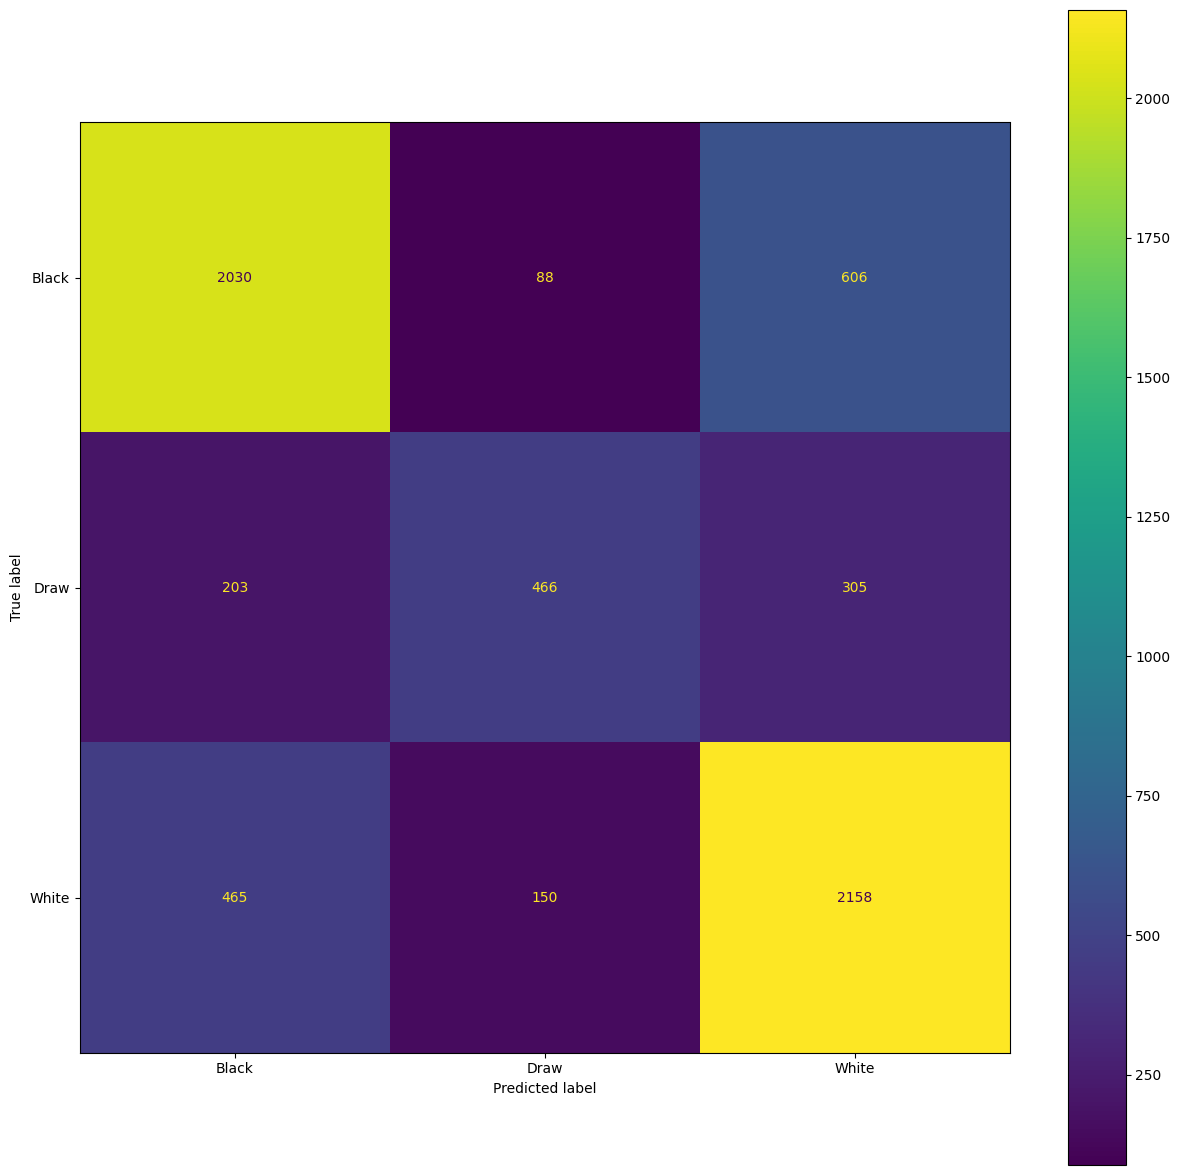

In [123]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# print('Training score using our best estimator: ', rf.score(X_train, y_train))
# print('Test score using our best estimator: ', rf.score(X_test, y_test))

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()